In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [91]:
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

## Pipeline

In [92]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [93]:
def define_y(inv, stock):
    y = inv[[stock]].shift(1)
    
    return y

In [94]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    return X_train, y_train, X_test, y_test

In [95]:
t = pd.to_datetime('2020-05-22')
n = 200
k = 20

In [96]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)

In [97]:
def formatX(investable_df):
    train_values = []
    # Iterates through each day in investable df and appends feature values to train_values
    for i in range(len(investable_df.index)):
        train_values.append(investable_df.iloc[i].values)
    train_values = np.array(train_values) # converts to numpy array
    train_values = np.reshape(train_values, (train_values.shape[0], 1, train_values.shape[1])) # reshapes to 3-dimensional
    return train_values

In [98]:
# Feature Scaling
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)

In [99]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# normalized with a MinMaxScaler to the range [0,1].

epochs = 250
batch_size = 1024

class simple_autoencoder():
    
    def __init__(self):
        pass
    
    def reduced_dim(self):
        encoding_dim = 20
        window_length = training_set_scaled.shape[1]
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # model mapping an input to its encoded representation
        encoder = Model(input_window, encoded)
        return pd.DataFrame(encoder.predict(test_set_scaled)).head()

    def model(self,optimizer = "Adam", score = 'mse', loss = "mean_squared_error", dim = 20):
        encoding_dim = dim
        window_length = training_set_scaled.shape[1]
        # input placeholder
        input_window = Input(shape=(window_length,))
        # encoded representation of the input
        encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
        # lossy reconstruction of the input
        decoded = Dense(window_length, activation='linear')(encoded) #linear
        # model mapping an input to its reconstruction
        simple_autoencoder = Model(input_window, decoded)
        simple_autoencoder.summary()
        sae = simple_autoencoder.compile(optimizer=optimizer, loss=loss, metrics=score) #MSE
        return simple_autoencoder

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto', verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)


model = simple_autoencoder()
history = model.model().fit(training_set_scaled, training_set_scaled,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks = [monitor, checkpointer])       
#                   validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder().model().predict(test_set_scaled)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                12900     
_________________________________________________________________
dense_7 (Dense)              (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 1s 664ms/step - loss: 0.2841 - mse: 0.2841 - val_loss: 0.2716 - val_mse: 0.2716
Epoch 2/250
1/1 [==============================] - 0s 41ms/step - loss: 0.2669 - mse: 0.2669 - val_loss: 0.2615 - val_mse: 0.2615
Epoch 3/250
1/1 [==============================] - 0s 57ms/step - loss: 0.2569 - mse: 0.2569 - val_loss: 0.2528 - val_mse: 0

Epoch 58/250
1/1 [==============================] - 0s 68ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 59/250
1/1 [==============================] - 0s 39ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 60/250
1/1 [==============================] - 0s 73ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 61/250
1/1 [==============================] - 0s 42ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 62/250
1/1 [==============================] - 0s 62ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 63/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 64/250
1/1 [==============================] - 0s 61ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 65/250
1/1 [==============================] - 0s 42ms/step - loss: 0.0104 - m

1/1 [==============================] - 0s 45ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 121/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 122/250
1/1 [==============================] - 0s 39ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 123/250
1/1 [==============================] - 0s 64ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 124/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 125/250
1/1 [==============================] - 0s 77ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 126/250
1/1 [==============================] - 0s 45ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 127/250
1/1 [==============================] - 0s 38ms/step - loss: 0.0093 - mse: 0.

1/1 [==============================] - 0s 80ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 183/250
1/1 [==============================] - 0s 65ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 184/250
1/1 [==============================] - 0s 61ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 185/250
1/1 [==============================] - 0s 62ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 186/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 187/250
1/1 [==============================] - 0s 43ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 188/250
1/1 [==============================] - 0s 40ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 189/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0087 - mse: 0.

1/1 [==============================] - 0s 79ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 245/250
1/1 [==============================] - 0s 66ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 246/250
1/1 [==============================] - 0s 55ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 247/250
1/1 [==============================] - 0s 48ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 248/250
1/1 [==============================] - 0s 50ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 249/250
1/1 [==============================] - 0s 61ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 250/250
1/1 [==============================] - 0s 52ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0110 - val_mse: 0.0110
Model: "model_5"
_________________________________________________________________
Layer (

In [100]:
X = simple_autoencoder().reduced_dim()
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.860265,0.623784,-0.451812,-0.175510,0.323413,-0.732693,0.596533,-0.447595,0.150045,-0.192876,-0.170092,-0.433506,0.594197,-0.600315,-0.303716,-0.428521,-0.181546,-0.692245,-0.217343,-0.643375
1,-0.935163,0.572346,-0.571604,-0.302163,0.239265,-0.713277,0.628787,-0.414250,0.236403,-0.008389,0.230399,-0.419604,0.069427,-0.739879,-0.455660,-0.502683,-0.041132,-0.817724,0.148061,-0.769557
2,-0.945177,0.538557,-0.330623,-0.074551,0.238072,-0.806628,0.552139,-0.494771,0.005719,-0.185727,0.183970,-0.550441,0.364848,-0.613470,-0.506859,-0.448307,0.202368,-0.875680,-0.325087,-0.821959
3,-0.905469,0.532433,-0.263821,-0.330193,-0.268161,-0.696798,0.755530,-0.297464,0.017223,-0.227357,0.012475,-0.417962,0.431776,-0.671384,-0.361287,-0.294243,-0.081829,-0.639741,-0.351742,-0.748321
4,-0.912663,0.505835,-0.285272,-0.122978,0.181963,-0.664202,0.658545,-0.507145,0.003105,-0.280495,0.230701,-0.405006,0.335078,-0.532611,-0.149079,-0.355105,-0.047211,-0.705326,-0.307947,-0.757478


In [101]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["val_mse"])
    plt.title("MSE")

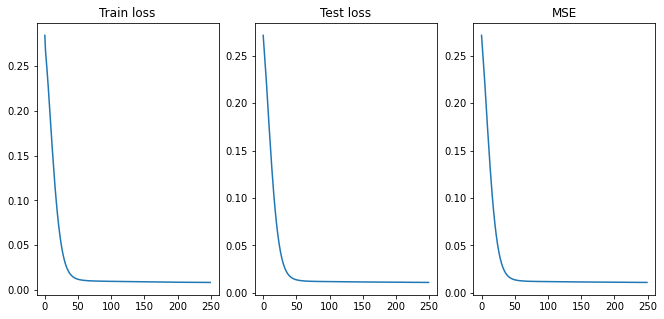

In [102]:
# Loss vs Epoch
plot_history(history)

In [103]:
y = define_y(df1, df1.columns[0])

In [104]:
y

,916328
date,
2018-05-11,NaN
2018-05-10,1.155878
2018-05-09,1.952862
2018-05-08,1.175268
2018-05-07,-1.028321
...,...
2016-05-24,1.843075
2016-05-23,1.632325
2016-05-20,-0.611702


In [105]:
X_train, y_train, X_test, y_test = train_test(X, y)

In [106]:
y_train

,916328
date,
2018-05-10,1.155878
2018-05-09,1.952862
2018-05-08,1.175268
2018-05-07,-1.028321
2018-05-04,0.987402
...,...
2016-05-24,1.843075
2016-05-23,1.632325
2016-05-20,-0.611702


In [107]:
y_test

,916328
date,
2018-05-11,NaN


In [108]:
def model_fit(X_train, y_train):
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    
    return model

In [109]:
def model_predict(model, X_test):
    yhat = model.predict(X_test)
    
    return yhat

In [110]:
def predict_returns(t, n, k):
    inv = get_investable(t, n)
    X = simple_autoencoder().reduced_dim()
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock)
        X_train, y_train, X_test, y_test = train_test(X, y)
        model = model_fit(X_train, y_train)
        yhat = model_predict(model, X_test)[0][0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test.values[0][0]
    
    return returns_t

In [111]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [112]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [113]:
def pipeline(n, k, num_stocks):

    time_range = df1.loc['2007':'2021'].index[:-1]
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    
    count = 0
    for t in time_range:
        pred_actual = predict_returns(t, n, k)
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc(t) + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    portfolio['Portfolio Return'] = portfolio['Portfolio Return'].astype('float')
    
    return portfolio

In [119]:
portfolio = pipeline(500, 20, 5)

In [120]:
#started at 3:07pm
print(pd.datetime.now())

2021-06-29 19:14:14.936898


In [121]:
portfolio

,Portfolio Return
date,


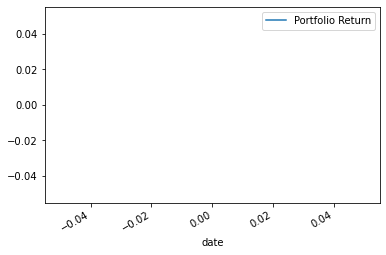

In [122]:
portfolio.plot()

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

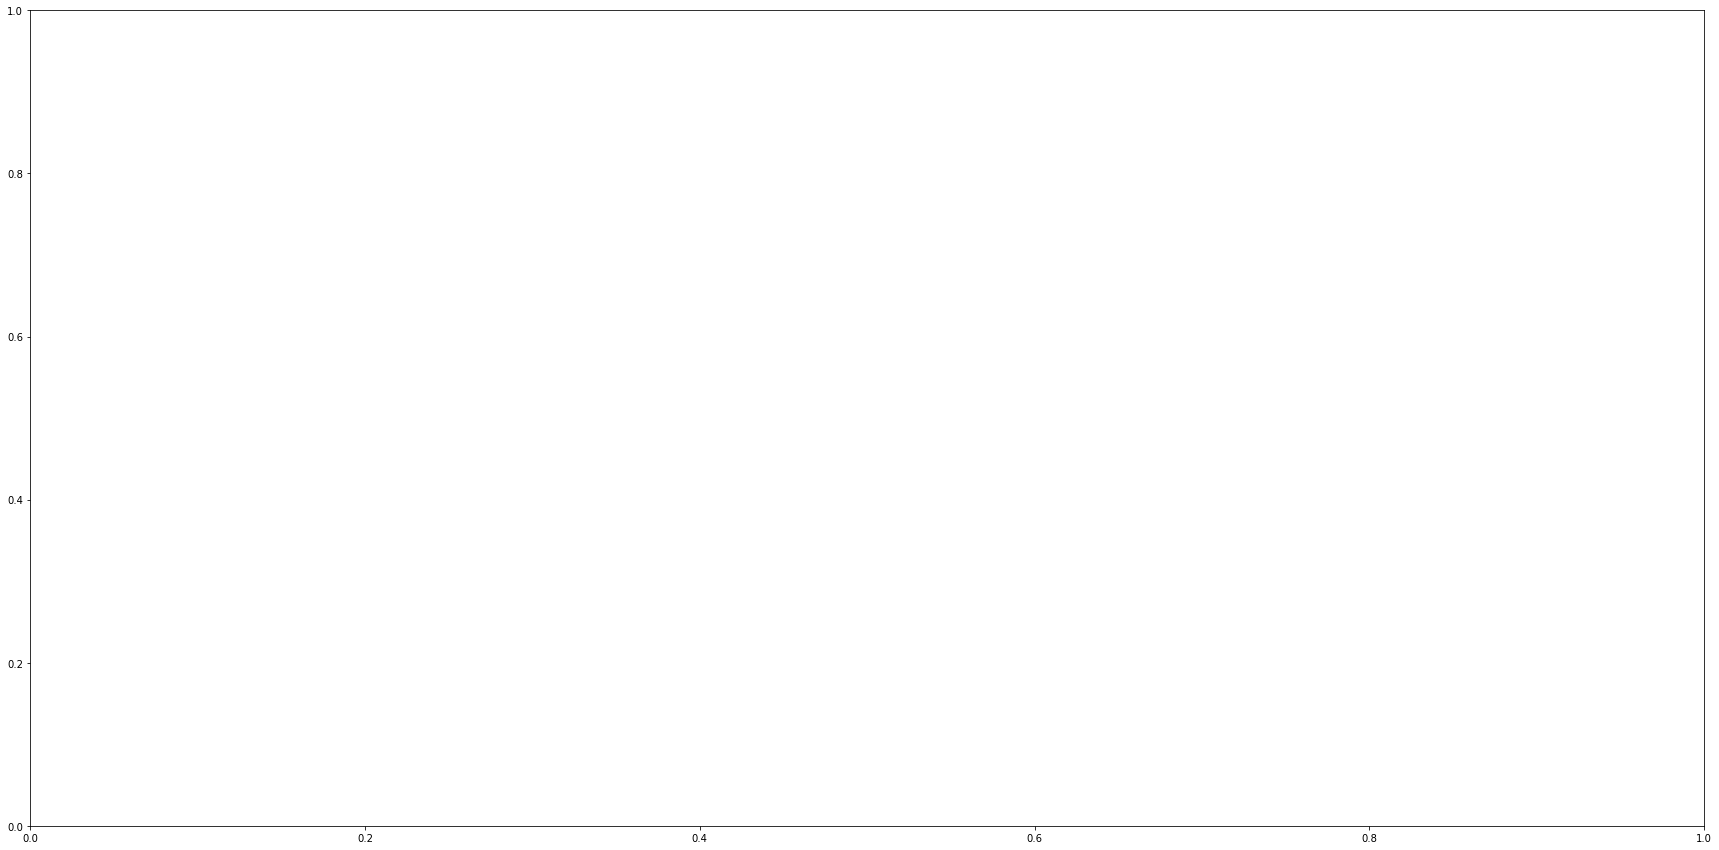

In [118]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(figsize=(30,15))
sns.barplot(x = portfolio.index, y = 'Portfolio Return', data = portfolio, color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_minor_locator(mdates.MonthLocator())

ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().index.to_period('Y')]

axes.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns')

sns.set(font_scale=2)
plt.axhline(0)

plt.tight_layout()


plt.show()

In [123]:
ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().loc['2007':'2021'].index.to_period('Y')]
ticklabels

[]

In [124]:
portfolio_monthly = portfolio.resample('M').mean()
portfolio_monthly

,Portfolio Return
date,


In [125]:
avg_return = portfolio['Portfolio Return'].mean()
print(f'Average return is {avg_return:.2f} %')

Average return is nan %


In [126]:
portfolio.to_csv('results/LinearRegression')

FileNotFoundError: [Errno 2] No such file or directory: 'results/LinearRegression'

In [127]:
df = pd.read_csv('results/LinearRegression', parse_dates = True, index_col = ['date'])

FileNotFoundError: [Errno 2] File results/LinearRegression does not exist: 'results/LinearRegression'

In [ ]:
df

In [ ]:
rolling_avg = pd.DataFrame(data = df['Portfolio Return'].rolling(252).mean())

In [ ]:
rolling_avg.dropna(inplace = True)

In [ ]:
rolling_avg

In [ ]:

fig, axes = plt.subplots(figsize=(30,15))
sns.barplot(x = df.index, y = 'Portfolio Return', data = df, color = 'grey')

axes.xaxis.set_major_locator(mdates.YearLocator())
axes.xaxis.set_minor_locator(mdates.MonthLocator())

ticklabels = [item.strftime('%Y') for item in portfolio.resample('Y').mean().index.to_period('Y')]

axes.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns')

sns.set(font_scale=2)
plt.axhline(0)

plt.tight_layout()


plt.show()

In [ ]:
sns.lineplot(x = rolling_avg.index, y = 'Portfolio Return', data = rolling_avg, color = 'black')
plt.xticks(rotation = 'vertical')
